In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.auto import AutoMLP
from neuralforecast.utils import AirPassengersDF

/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# We define the train df. 
Y_df = AirPassengersDF
Y_df.head()

,unique_id,ds,y
0,1.0,1949-01-31,112.0
1,1.0,1949-02-28,118.0
2,1.0,1949-03-31,132.0
3,1.0,1949-04-30,129.0
4,1.0,1949-05-31,121.0


In [3]:
Y_train_df = Y_df[Y_df.ds<='1959-12-31'] # 132 train
Y_test_df = Y_df[Y_df.ds>'1959-12-31'] # 12 test

In [4]:
%%capture
horizon = len(Y_test_df)
config = dict(max_steps=1, input_size=12)
models = [NBEATS(input_size=2 * horizon, h=horizon, max_epochs=1),
          NBEATS(input_size=3 * horizon, h=horizon, max_epochs=1),
          NHITS(input_size=2 * horizon, h=horizon, max_epochs=1),
          AutoMLP(h=12, config=config, num_samples=1, cpus=1)]
fcst = NeuralForecast(models=models, freq='M')

In [5]:
fcst.fit(df=Y_train_df)

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(train_tune pid=35646) /Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(train_tune pid=35646)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0:  50%|█████     | 1/2 [00:00<00:00, 23.97it/s, loss=254, v_num=0, train_loss_step=254.0]
Validation: 0it [00:00, ?it/s]0m 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 15.11it/s, loss=254, v_num=3, train_loss_step=254.0, val_loss=231.0, train_loss_epoch=254.0]


Using stored dataset.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 158.25it/s]


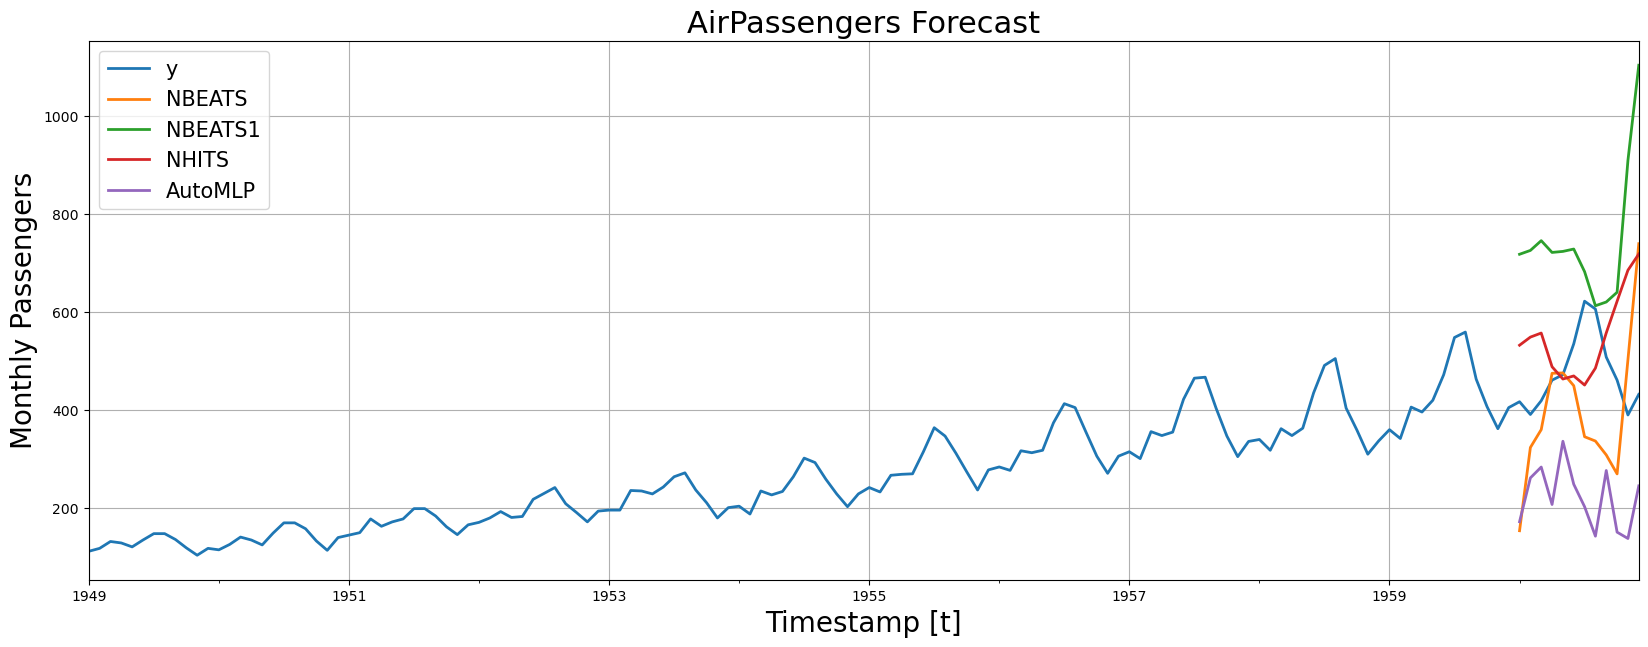

In [6]:
Y_hat_df = fcst.predict().reset_index()
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NBEATS1', 'NHITS', 'AutoMLP']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [7]:
fcst.save(path='./checkpoints/test_run/', model_index=None, overwrite=True, save_dataset=True)

In [8]:
fcst2 = NeuralForecast.load(path='./checkpoints/test_run/')

---------- Loading models ----------
Model nbeats loaded.
Model automlp loaded.
Model nhits loaded.
Model nbeats loaded.
Loaded 4 models.
---------- Loading dataset ----------
Dataset loaded.
---------- Loading configuration ----------
Configuration loaded.


Using stored dataset.
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.43it/s]


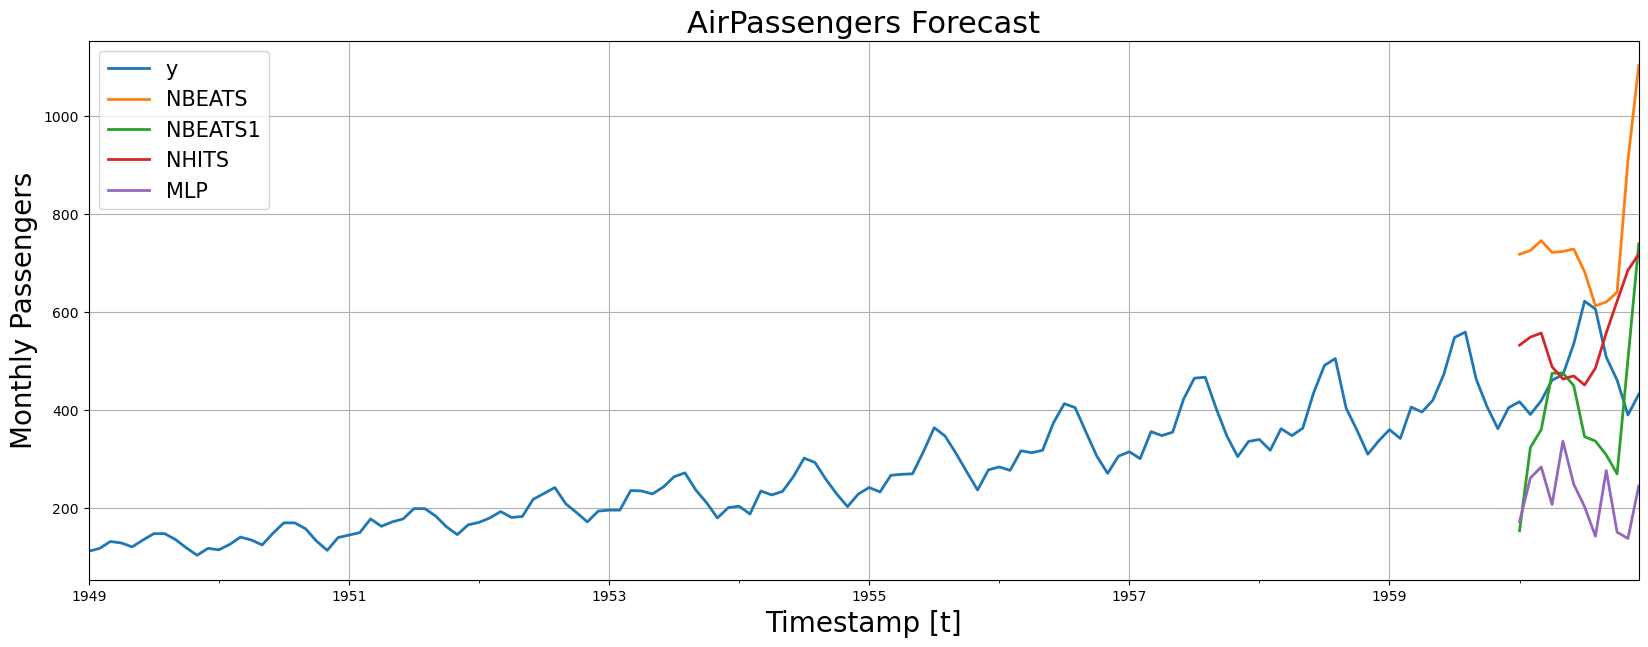

In [9]:
Y_hat_df = fcst2.predict().reset_index()
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NBEATS1', 'NHITS', 'MLP']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()